In [2]:
var ROOT_PATH = "/home/node/notebook/src/open_digger"
var openDigger = require(ROOT_PATH)
var repoId = 22542759

访问clickhouse，查看数据库

In [3]:
var query = openDigger.driver.clickhouse.query;
query(
    `SHOW DATABASES`
)
.then(res=>{
    console.log(res);
})

[
  { name: '_temporary_and_external_tables' },
  { name: 'default' },
  { name: 'github_log' },
  { name: 'system' }
]


查看github_log数据库中有哪些表

In [6]:
//查看数据库有哪些表
query(
    `SHOW TABLES from github_log`
)
.then(res=>{
    console.log(res);
})

[ { name: 'events' } ]


查看event表中的列名信息,跟期中的schema一致

In [7]:
query(
    `select distinct name from system.columns where database='github_log' and table='events'`
)
.then(res=>{
    console.log(res);
})

[
  { name: 'id' },
  { name: 'type' },
  { name: 'action' },
  { name: 'actor_id' },
  { name: 'actor_login' },
  { name: 'repo_id' },
  { name: 'repo_name' },
  { name: 'org_id' },
  { name: 'org_login' },
  { name: 'created_at' },
  { name: 'issue_id' },
  { name: 'issue_number' },
  { name: 'issue_title' },
  { name: 'body' },
  { name: 'issue_labels.name' },
  { name: 'issue_labels.color' },
  { name: 'issue_labels.default' },
  { name: 'issue_labels.description' },
  { name: 'issue_author_id' },
  { name: 'issue_author_login' },
  { name: 'issue_author_type' },
  { name: 'issue_author_association' },
  { name: 'issue_assignee_id' },
  { name: 'issue_assignee_login' },
  { name: 'issue_assignees.login' },
  { name: 'issue_assignees.id' },
  { name: 'issue_created_at' },
  { name: 'issue_updated_at' },
  { name: 'issue_comments' },
  { name: 'issue_closed_at' },
  { name: 'issue_comment_id' },
  { name: 'issue_comment_created_at' },
  { name: 'issue_comment_updated_at' },
  { name:

查看有哪些类型的event

In [33]:
query(
    `select distinct(type) from github_log.events`
)
.then(res=>{
    console.log(res);
})

[
  { type: 'CommitCommentEvent' },
  { type: 'CreateEvent' },
  { type: 'DeleteEvent' },
  { type: 'ForkEvent' },
  { type: 'GollumEvent' },
  { type: 'IssueCommentEvent' },
  { type: 'PushEvent' },
  { type: 'IssuesEvent' },
  { type: 'MemberEvent' },
  { type: 'PullRequestEvent' },
  { type: 'PullRequestReviewCommentEvent' },
  { type: 'ReleaseEvent' },
  { type: 'WatchEvent' },
  { type: 'PublicEvent' }
]


# 每月新增 Star和Fork的个数

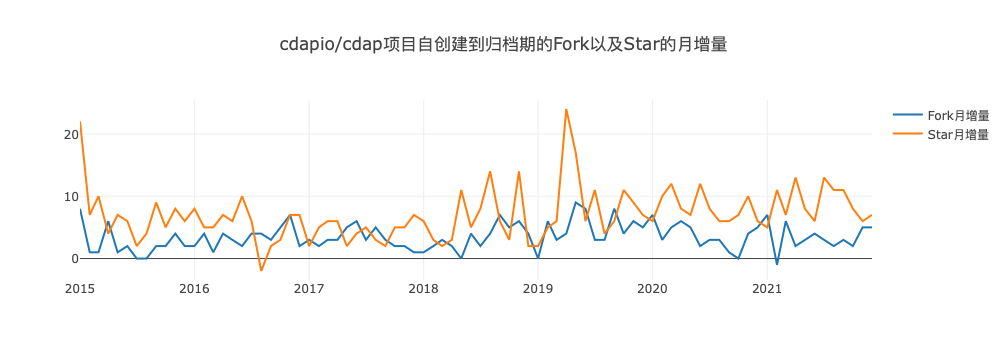

┌─────────┬───────────┬────────────┬────────────┐
│ (index) │   日期    │ Fork月增量 │ Star月增量 │
├─────────┼───────────┼────────────┼────────────┤
│    0    │ '2015-01' │     8      │     22     │
│    1    │ '2015-02' │     1      │     7      │
│    2    │ '2015-03' │     1      │     10     │
│    3    │ '2015-04' │     6      │     4      │
│    4    │ '2015-05' │     1      │     7      │
│    5    │ '2015-06' │     2      │     6      │
│    6    │ '2015-07' │     0      │     2      │
│    7    │ '2015-08' │     0      │     4      │
│    8    │ '2015-09' │     2      │     9      │
│    9    │ '2015-10' │     2      │     5      │
│   10    │ '2015-11' │     4      │     8      │
│   11    │ '2015-12' │     2      │     6      │
│   12    │ '2016-01' │     2      │     8      │
│   13    │ '2016-02' │     4      │     5      │
│   14    │ '2016-03' │     1      │     5      │
│   15    │ '2016-04' │     4      │     7      │
│   16    │ '2016-05' │     3      │     6      │
│   17  

In [3]:
query(
    `select toYear(created_at) as year, toMonth(created_at) as month, repo_forks_count, repo_stargazers_count
     from github_log.events
     where id in
        (select max(id)
         from github_log.events where repo_id=22542759 
            and type in ('PullRequestEvent','PullRequestReviewCommentEvent')
            and toYear(created_at) < 2022
         group by(toYear(created_at), toMonth(created_at))
         )
    order by(year, month)`
).then(data => {
    var year = [], month = [], repoForkNum = [], repoStarNum = [], repoForkInc = [], repoStarInc = [];
    
    year = data.map(d => d.year);
    month = data.map(d => d.month);
    repoForkNum = data.map(d => d.repo_forks_count);
    repoStarNum = data.map(d => d.repo_stargazers_count);

    var xAxis = [];
    var tableList = [];

    for(var i=0; i<year.length; i++){
        xAxis.push(year[i]+'-'+month[i].toString().padStart(2, '0'));
        if(i) {
            repoForkInc.push(repoForkNum[i] - repoForkNum[i-1]);
            repoStarInc.push(repoStarNum[i] - repoStarNum[i-1]);        
        } else {
            repoForkInc.push(repoForkNum[i]);
            repoStarInc.push(repoStarNum[i]);        
        }
        tableList.push([xAxis[i], repoForkInc[i], repoStarInc[i]])

    }
    openDigger.render.plotly([
        {x: xAxis, y: repoForkInc, mode: 'scatter', name: 'Fork月增量'},
        {x: xAxis, y: repoStarInc, mode: 'scatter', name: 'Star月增量'}
    ], {
        title: 'cdapio/cdap项目自创建到归档期的Fork以及Star的月增量',
        xais: {type: 'category'}
    });
    console.table(tableList.map((l, i) => {
        return {
            '日期': l[0],
            'Fork月增量': l[1],
            'Star月增量': l[2]
        };
    
    }));
});

# 3. 每月打开 PR 和合入 PR 的个数（注意，关闭 PR 不等于合入）

## 3.1 每月打开PR的个数

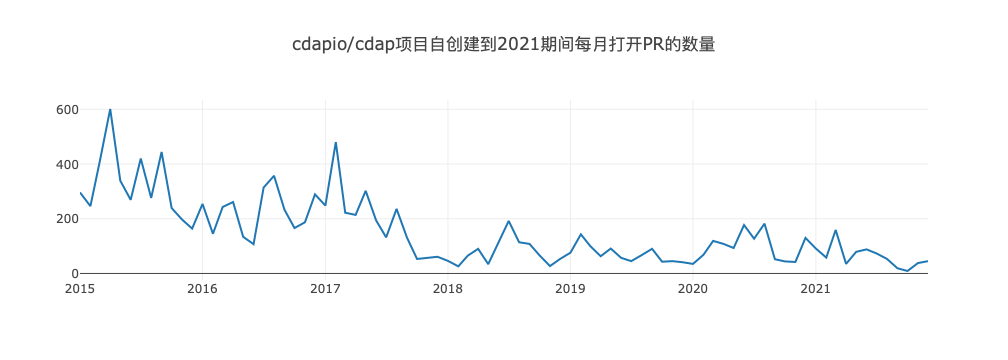

┌─────────┬───────────┬────────────┐
│ (index) │   日期    │ PR打开月量 │
├─────────┼───────────┼────────────┤
│    0    │ '2015-01' │   '296'    │
│    1    │ '2015-02' │   '246'    │
│    2    │ '2015-03' │   '410'    │
│    3    │ '2015-04' │   '601'    │
│    4    │ '2015-05' │   '339'    │
│    5    │ '2015-06' │   '269'    │
│    6    │ '2015-07' │   '420'    │
│    7    │ '2015-08' │   '276'    │
│    8    │ '2015-09' │   '444'    │
│    9    │ '2015-10' │   '239'    │
│   10    │ '2015-11' │   '197'    │
│   11    │ '2015-12' │   '164'    │
│   12    │ '2016-01' │   '254'    │
│   13    │ '2016-02' │   '145'    │
│   14    │ '2016-03' │   '243'    │
│   15    │ '2016-04' │   '261'    │
│   16    │ '2016-05' │   '134'    │
│   17    │ '2016-06' │   '107'    │
│   18    │ '2016-07' │   '314'    │
│   19    │ '2016-08' │   '357'    │
│   20    │ '2016-09' │   '233'    │
│   21    │ '2016-10' │   '166'    │
│   22    │ '2016-11' │   '187'    │
│   23    │ '2016-12' │   '289'    │
│   24 

In [5]:
//每月打开PR的个数
query(
    `select year, month, count(issue_id) AS PRCreateCount
    from
    (
        select toYear(issue_created_at) AS year, toMonth(issue_created_at) AS month, issue_id  
        from github_log.events
        where repo_id = 22542759
        and type = 'PullRequestEvent'
        and action = 'opened'
        and toYear(issue_created_at) < 2022
    )t1
    group by (year, month)
    order by (year, month)`
).then(data=> {
    var year = [], month = [], PRCreateCount = [];
    
    year = data.map(d => d.year);
    month = data.map(d => d.month);
    PRCreateCount = data.map(d => d.PRCreateCount);
    

    var xAxis = [];
    var tableList = [];
    for(var i=0; i<year.length; i++){
        xAxis.push(year[i]+'-'+month[i].toString().padStart(2, '0'));
        tableList.push([xAxis[i], PRCreateCount[i]])
    }
    openDigger.render.plotly([
        {x: xAxis, y: PRCreateCount, mode: 'scatter', name: 'PR打开月数量'}
    ], {
        title: 'cdapio/cdap项目自创建到2021期间每月打开PR的数量',
        xais: {type: 'category'}
    });
    console.table(tableList.map((l, i) => {
        return {
            '日期': l[0],
            'PR打开月量': l[1]
        }
    }));
});

## 3.2 每月合入PR的个数

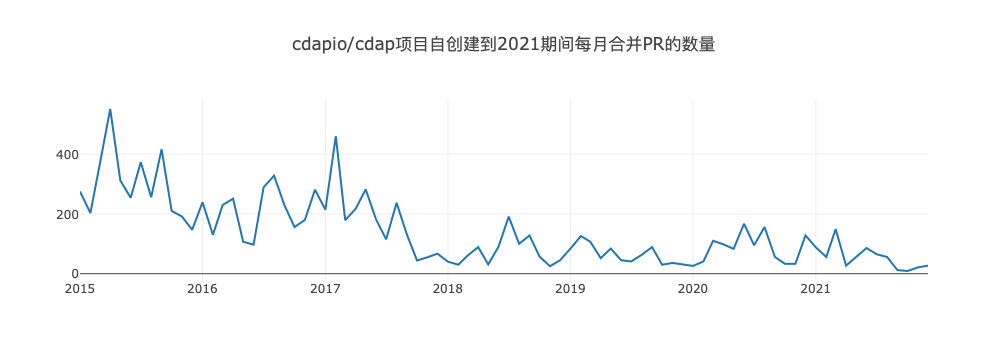

┌─────────┬───────────┬────────────┐
│ (index) │   日期    │ PR合入月量 │
├─────────┼───────────┼────────────┤
│    0    │ '2015-01' │   '275'    │
│    1    │ '2015-02' │   '203'    │
│    2    │ '2015-03' │   '367'    │
│    3    │ '2015-04' │   '551'    │
│    4    │ '2015-05' │   '312'    │
│    5    │ '2015-06' │   '254'    │
│    6    │ '2015-07' │   '373'    │
│    7    │ '2015-08' │   '256'    │
│    8    │ '2015-09' │   '416'    │
│    9    │ '2015-10' │   '210'    │
│   10    │ '2015-11' │   '191'    │
│   11    │ '2015-12' │   '147'    │
│   12    │ '2016-01' │   '239'    │
│   13    │ '2016-02' │   '130'    │
│   14    │ '2016-03' │   '230'    │
│   15    │ '2016-04' │   '251'    │
│   16    │ '2016-05' │   '107'    │
│   17    │ '2016-06' │    '97'    │
│   18    │ '2016-07' │   '289'    │
│   19    │ '2016-08' │   '328'    │
│   20    │ '2016-09' │   '229'    │
│   21    │ '2016-10' │   '156'    │
│   22    │ '2016-11' │   '180'    │
│   23    │ '2016-12' │   '281'    │
│   24 

In [6]:
//每月合入PR的个数
query(
    `select year, month, count(issue_id) AS PRMergeCount
    from 
    (
        select toYear(pull_merged_at) AS year, toMonth(pull_merged_at) AS month, issue_id
        from github_log.events
        where repo_id = 22542759
            and type = 'PullRequestEvent'
            and pull_merged = 1
            and toYear(pull_merged_at) < 2022
    )t1
    group by (year, month)
    order by (year, month)`
).then(data=> {
    var year = [], month = [], PRMergeCount = [];
    year = data.map(d => d.year);
    month = data.map(d => d.month);
    PRMergeCount = data.map(d => d.PRMergeCount);
    

    var xAxis = [];
    var tableList = [];
    for(var i=0; i<year.length; i++){
        xAxis.push(year[i]+'-'+month[i].toString().padStart(2, '0'));
        tableList.push([xAxis[i], PRMergeCount[i]])
    }
    openDigger.render.plotly([
        {x: xAxis, y: PRMergeCount, mode: 'scatter', name: 'PR合并月数量'}
    ], {
        title: 'cdapio/cdap项目自创建到2021期间每月合并PR的数量',
        xais: {type: 'category'}
    });
    console.table(tableList.map((l, i) => {
        return {
            '日期': l[0],
            'PR合入月量': l[1]
        }
    }));
})

# 7. Issue和PR从打开到第一次有人回复（非本人回复）的平均时长和中位数（单位：天）

## 7.1 Issue从打开到第一次有人回复（非本人回复）的平均时长和中位数（单位：天）

In [39]:
query(
    `select avg(dateDiff('day', create_time, comment_time))As average, quantile(dateDiff('day', create_time, comment_time)) AS median
    from 
    (select min(issue_comment_created_at) AS comment_time, min(issue_created_at) AS create_time
        from github_log.events
        where repo_id = 22542759
        and type = 'IssueCommentEvent'
        and issue_comment_author_id <> issue_author_id
        group by issue_id)t2`
).then(data => {console.log(data)});

[ { average: 1.772310610051628, median: 0 } ]


## 7.2 PR从打开到第一次有人回复（非本人回复）的平均时长和中位数（单位：天）

In [5]:
query(
    `select avg(dateDiff('day', create_time, comment_time))As average, quantile(dateDiff('day', create_time, comment_time)) AS median
    from
        (select issue_id, issue_created_at AS create_time
        from github_log.events
        where repo_id = 22542759
        and type = 'PullRequestEvent'
        and action = 'opened'
        and toYear(issue_created_at)<2022)t1, 
        (select issue_id, min(pull_review_comment_created_at) AS comment_time
        from github_log.events
        where repo_id = 22542759
        and type = 'PullRequestReviewCommentEvent'
        and issue_author_id <> pull_review_comment_author_id
        and toYear(pull_review_comment_created_at) < 2022
        group by issue_id)t2
    where t1.issue_id = t2.issue_id
`
).then(data => {console.log(data)});

[ { average: 1.216278101582015, median: 0 } ]
